**Forecasting House Prices Accurately using Smart Regression Techniques in Data Science**

**Import**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


**Dataset Loading**

In [5]:
# Load dataset
url = 'house.csv'
df = pd.read_csv(url)
print("Initial Dataset Loaded.")
print(df.head())


Initial Dataset Loaded.
      crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        b  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  


**Data Cleaning and Preparation**


Missing Values Check:
 crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
b          0
lstat      0
medv       0
dtype: int64
Number of duplicate records: 0


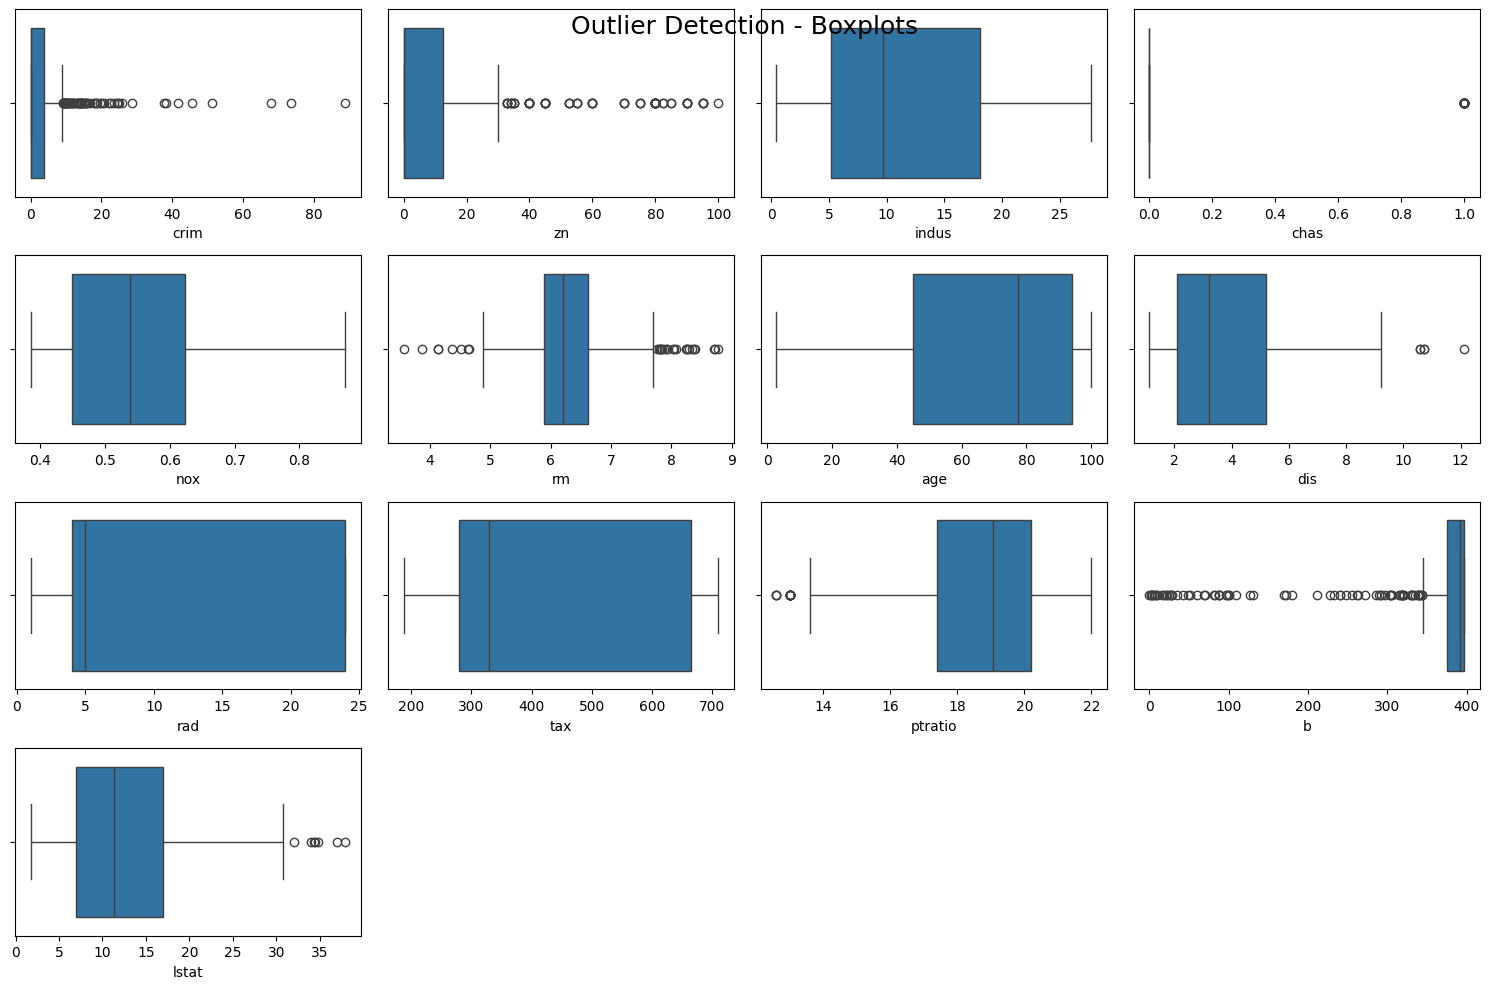


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB
None


In [6]:
# Check missing values
print("\nMissing Values Check:\n", df.isnull().sum())

# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate records: {duplicates}")

# Drop duplicates if any
df.drop_duplicates(inplace=True)

# Outlier visualization
plt.figure(figsize=(15, 10))
for i, col in enumerate(df.columns[:-1], 1):
    plt.subplot(4, 4, i)
    sns.boxplot(data=df, x=col)
    plt.tight_layout()
plt.suptitle("Outlier Detection - Boxplots", fontsize=18)
plt.show()

# Note: We'll retain outliers because tree-based models are robust to them.

# Data types
print("\nDataset Info:")
print(df.info())


**Feature Engineering**

In [7]:
# Rooms per dwelling unit ratio
df['rm_per_age'] = df['rm'] / df['age']  # newer homes with more rooms may be more valuable
# Distance to employment centers ratio
df['dis_per_rad'] = df['dis'] / df['rad']  # accessibility vs. distance to employment hubs
# Tax to pupil-teacher ratio
df['tax_ptratio_ratio'] = df['tax'] / df['ptratio']  # reflects quality of services vs. tax burden

# Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[['lstat', 'rm']])
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(['lstat', 'rm']))
df = pd.concat([df, poly_df[['lstat^2', 'rm^2', 'lstat rm']]], axis=1)

# Binning Age
df['age_binned'] = pd.cut(df['age'], bins=[0, 35, 70, 100], labels=['New', 'Mid-aged', 'Old'])
df = pd.get_dummies(df, columns=['age_binned'], drop_first=True)


**Exploratory Data Analysis (EDA)**

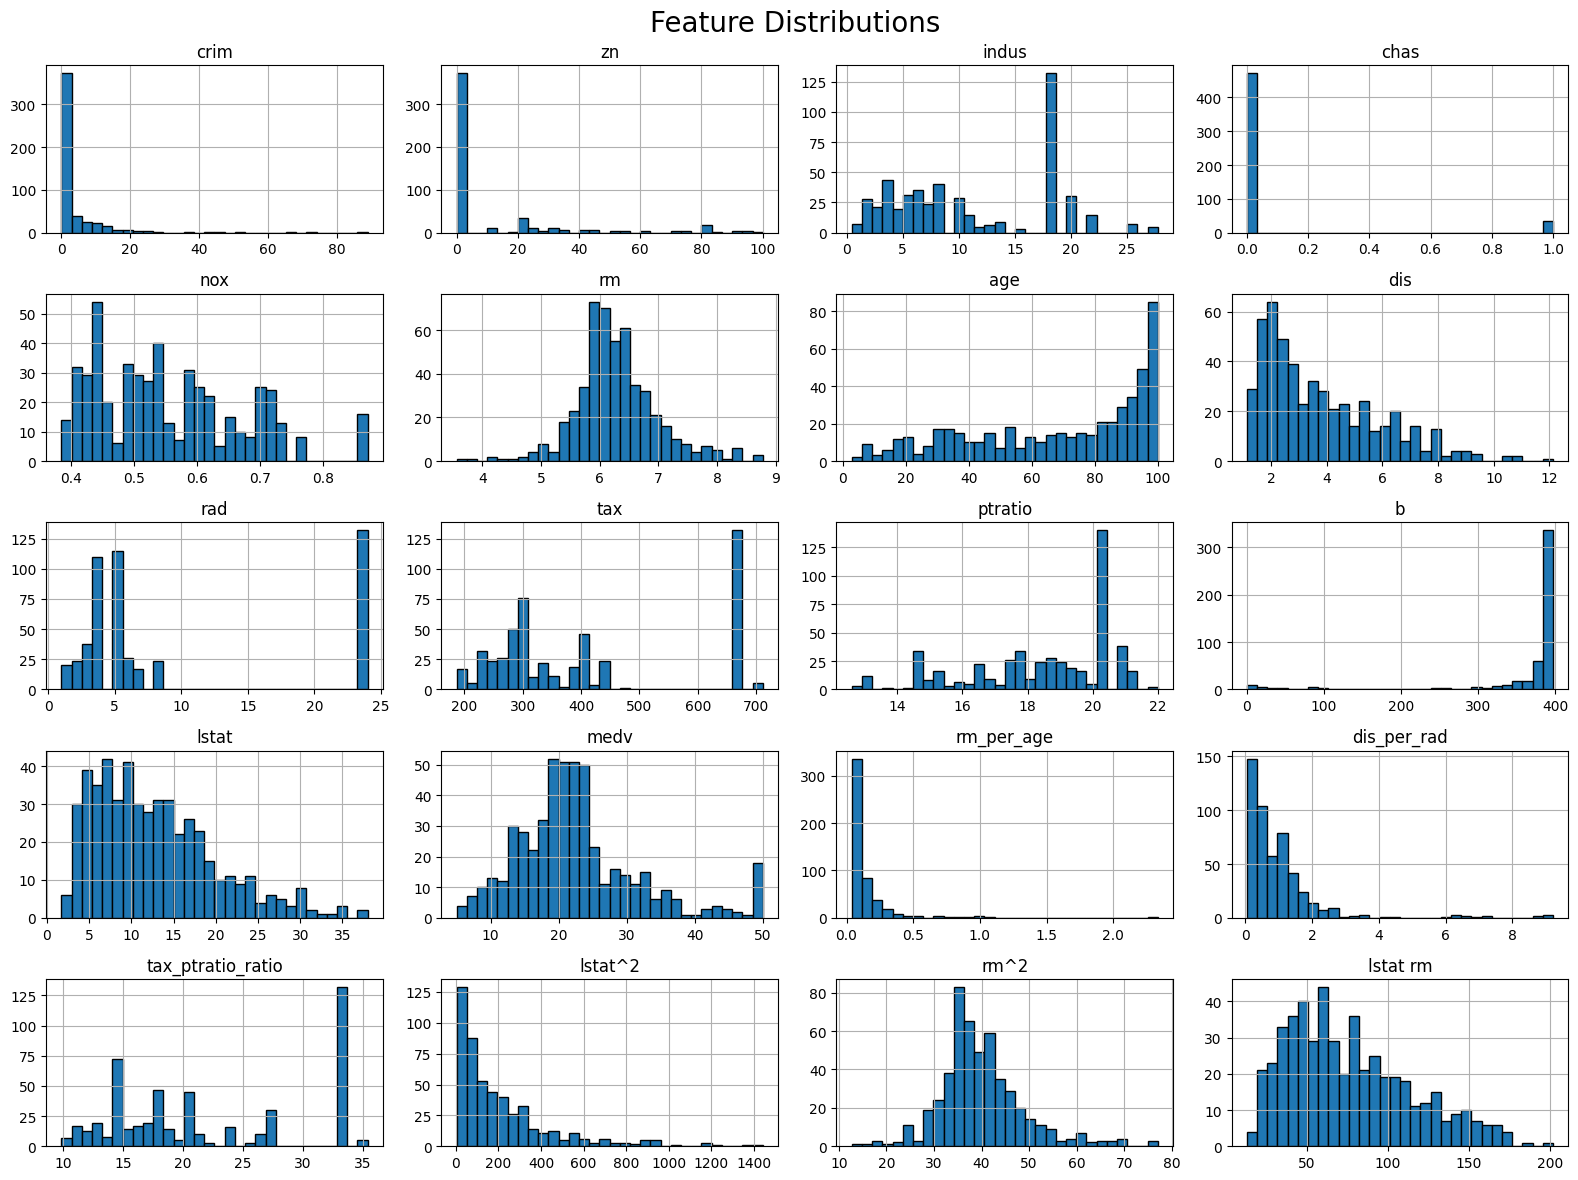

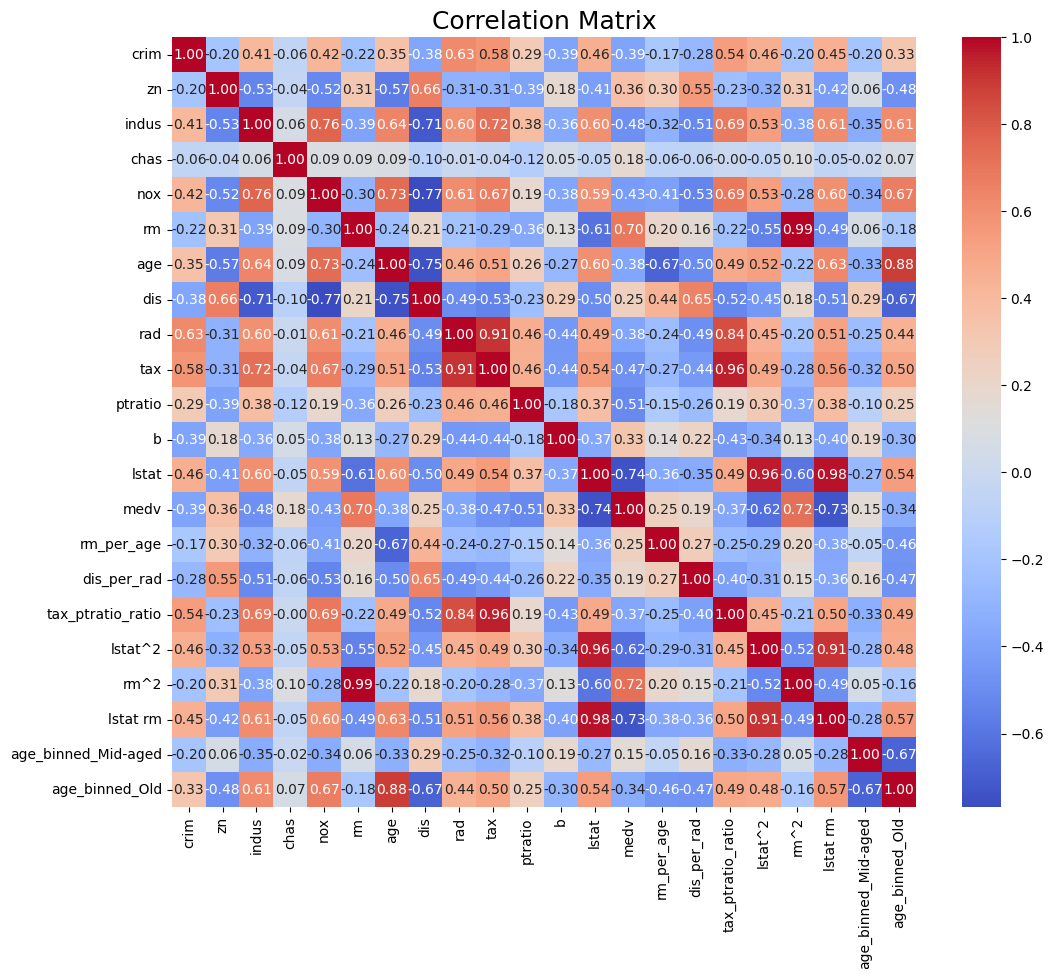

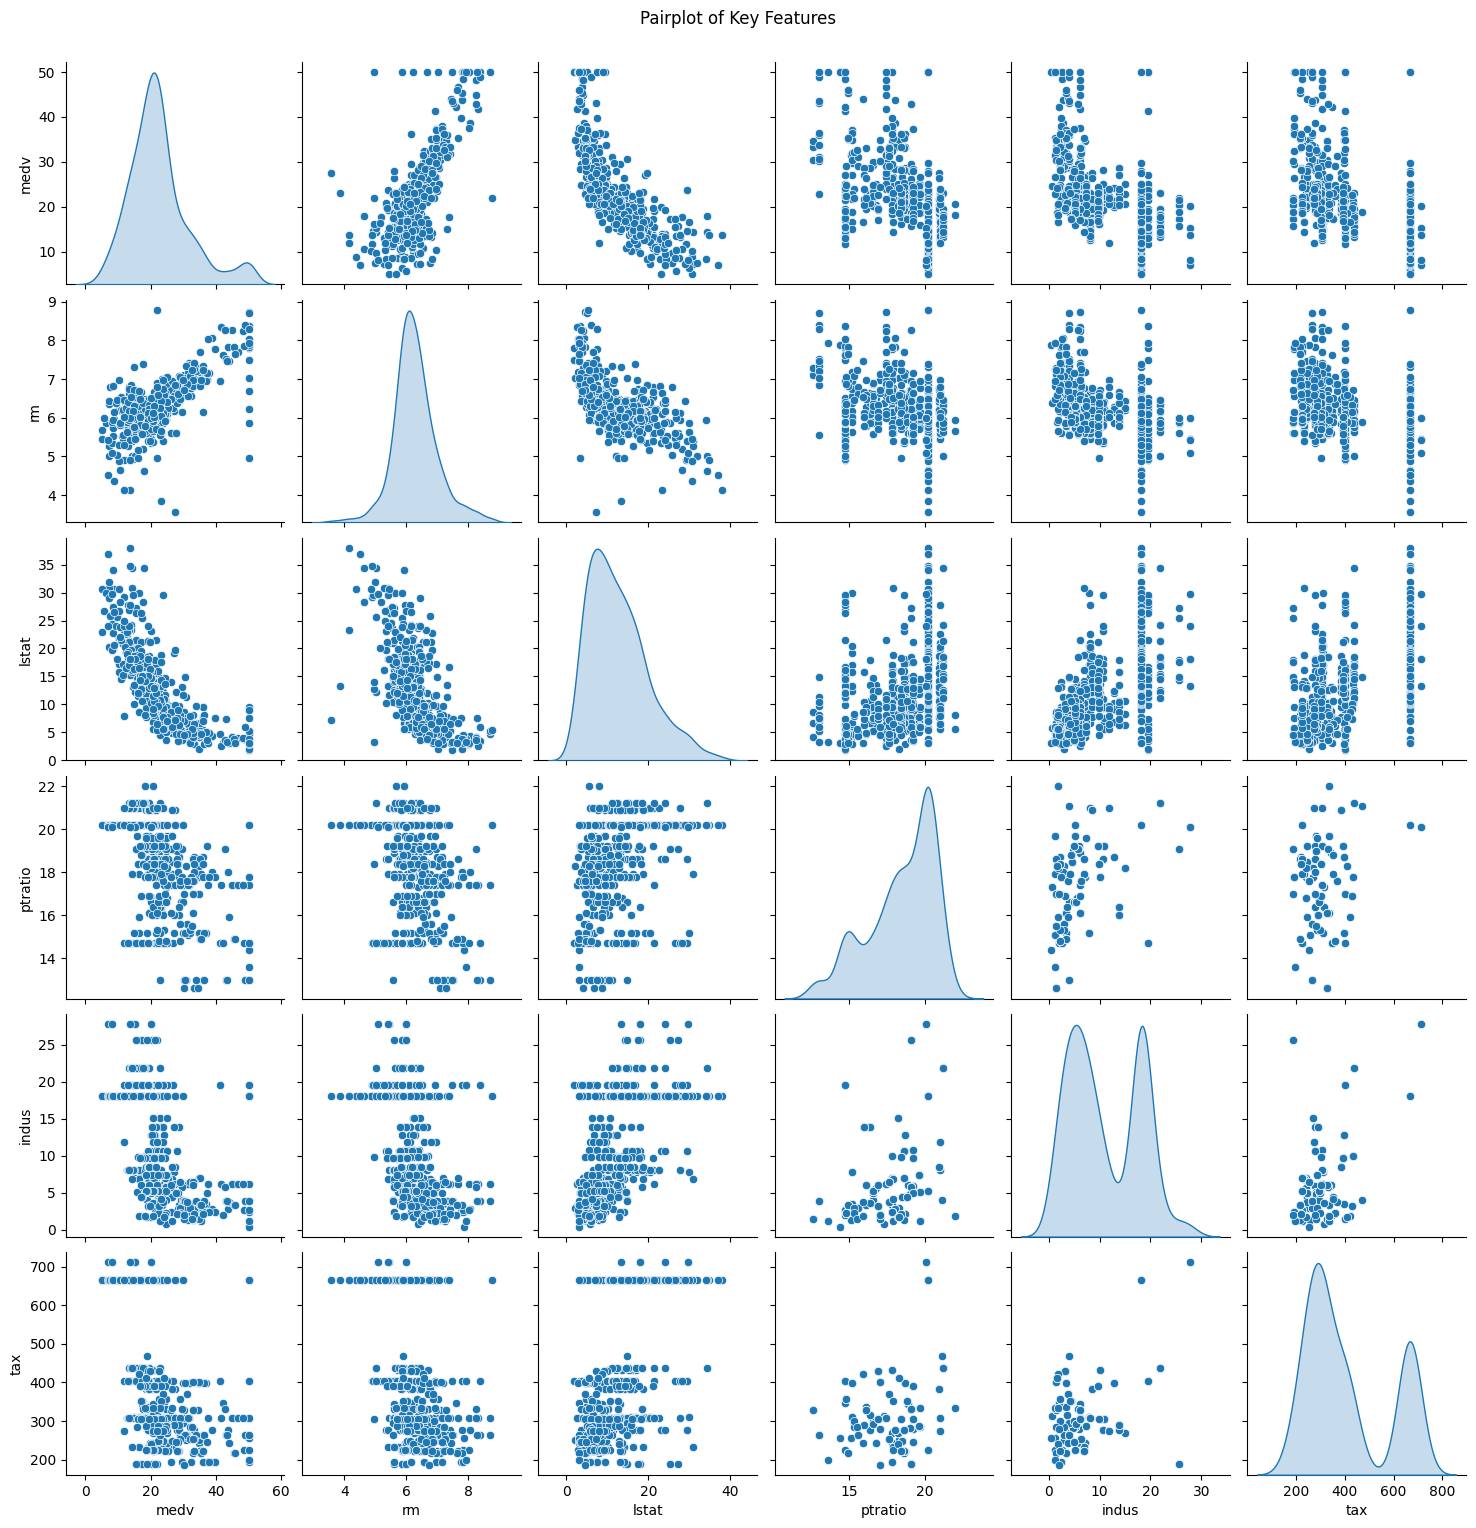

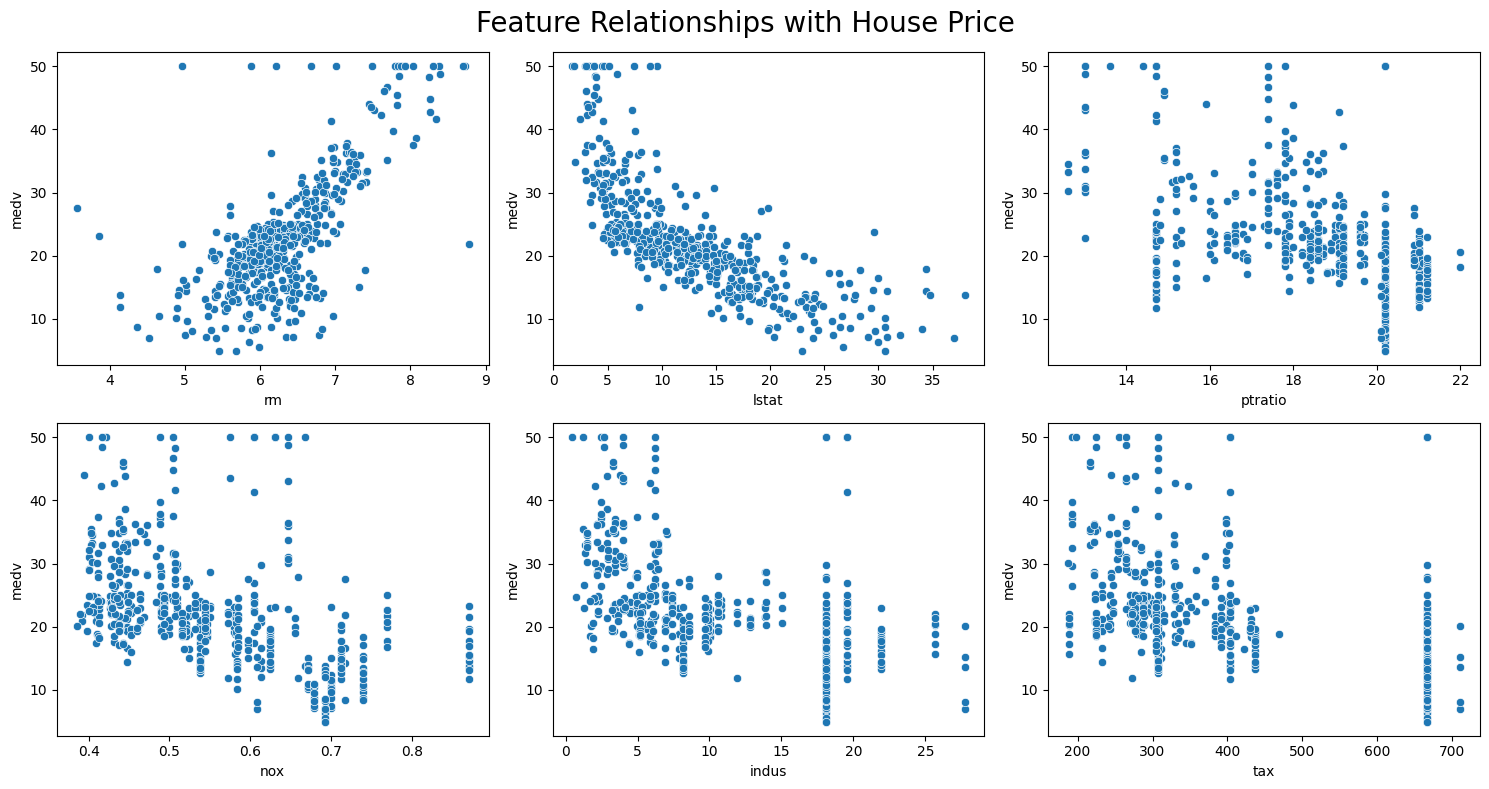

C:\Users\balav\AppData\Local\Temp\ipykernel_19472\3623254956.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='chas', y='medv', data=df, palette='cool')


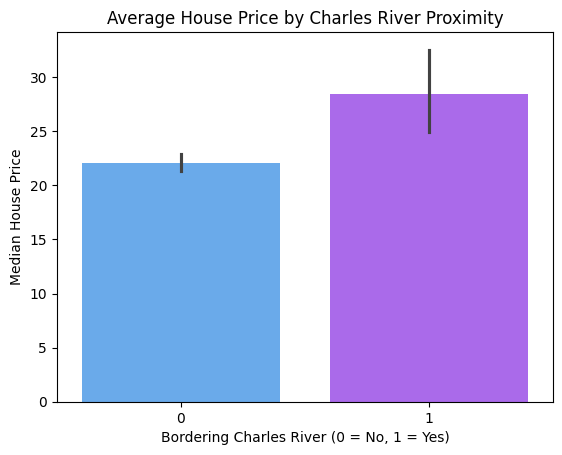

In [8]:
# Histograms
df.hist(figsize=(16, 12), bins=30, edgecolor='black')
plt.suptitle('Feature Distributions', fontsize=20)
plt.tight_layout()
plt.show()

# Correlation Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix', fontsize=18)
plt.show()

# Pairplot (Subset to avoid overload)
sns.pairplot(df[['medv', 'rm', 'lstat', 'ptratio', 'indus', 'tax']], diag_kind='kde')
plt.suptitle('Pairplot of Key Features', y=1.02)
plt.show()

# Scatterplots (Selected Features vs Target)
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
sns.scatterplot(data=df, x='rm', y='medv', ax=axs[0, 0])
sns.scatterplot(data=df, x='lstat', y='medv', ax=axs[0, 1])
sns.scatterplot(data=df, x='ptratio', y='medv', ax=axs[0, 2])
sns.scatterplot(data=df, x='nox', y='medv', ax=axs[1, 0])
sns.scatterplot(data=df, x='indus', y='medv', ax=axs[1, 1])
sns.scatterplot(data=df, x='tax', y='medv', ax=axs[1, 2])
fig.suptitle("Feature Relationships with House Price", fontsize=20)
plt.tight_layout()
plt.show()

# CHAS Variable
sns.barplot(x='chas', y='medv', data=df, palette='cool')
plt.title('Average House Price by Charles River Proximity')
plt.xlabel('Bordering Charles River (0 = No, 1 = Yes)')
plt.ylabel('Median House Price')
plt.show()


**Model Building**

In [9]:
# Define X and y(FEATURES AND TARGET)
X = df.drop("medv", axis=1)
y = df["medv"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization(SCALING)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1)
}

# Train and Evaluate
results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    results[name] = {
        "R² Score": r2_score(y_test, preds),
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": np.sqrt(mean_squared_error(y_test, preds))  # <- corrected
    }


**Model Evaluation**

In [10]:
# Display Results
print("\nModel Performance Comparison:")
for model_name, metrics in results.items():
    print(f"{model_name} --> R²: {metrics['R² Score']:.4f}, MAE: {metrics['MAE']:.2f}, RMSE: {metrics['RMSE']:.2f}")



Model Performance Comparison:
Linear Regression --> R²: 0.8105, MAE: 2.39, RMSE: 3.73
Ridge Regression --> R²: 0.8032, MAE: 2.50, RMSE: 3.80
Lasso Regression --> R²: 0.7659, MAE: 2.65, RMSE: 4.14
Random Forest --> R²: 0.8987, MAE: 2.02, RMSE: 2.73
XGBoost --> R²: 0.9069, MAE: 1.84, RMSE: 2.61


**Visualization of Results**

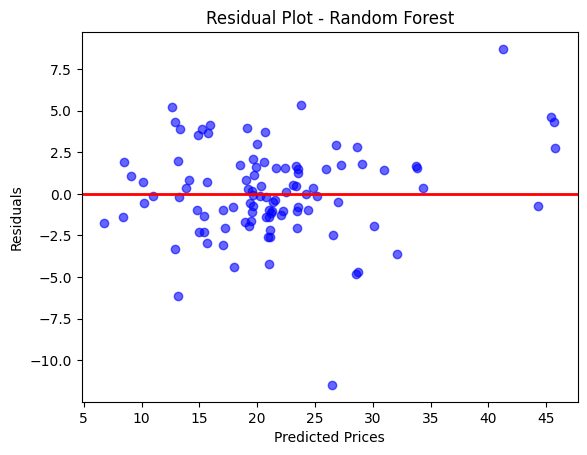

C:\Users\balav\AppData\Local\Temp\ipykernel_19472\1757060509.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=features, palette='viridis')


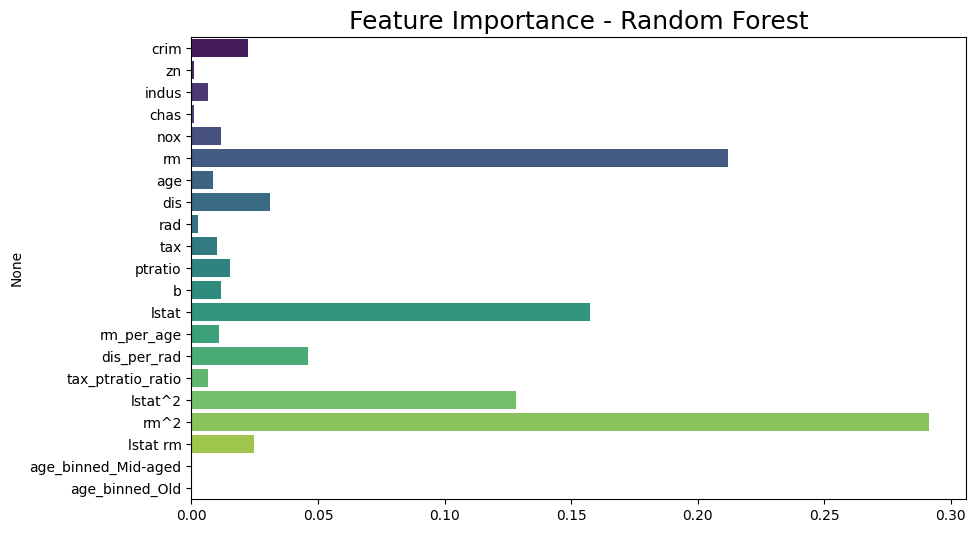

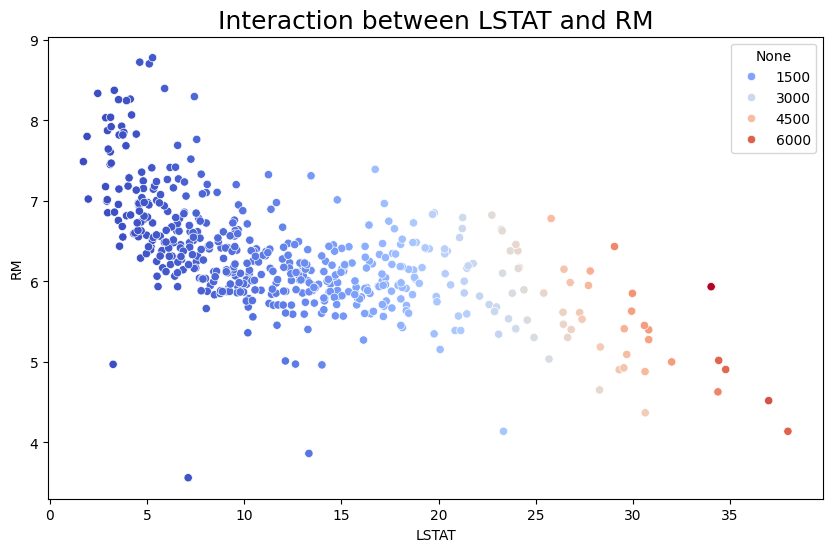

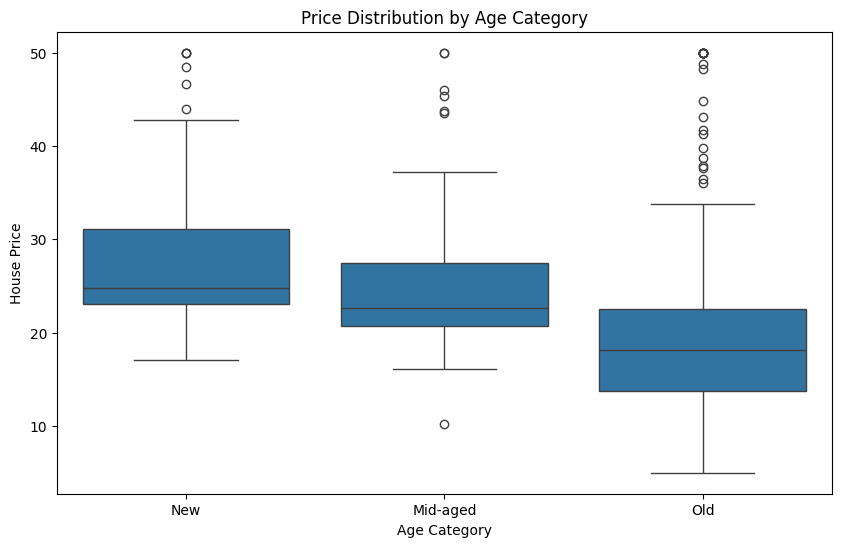

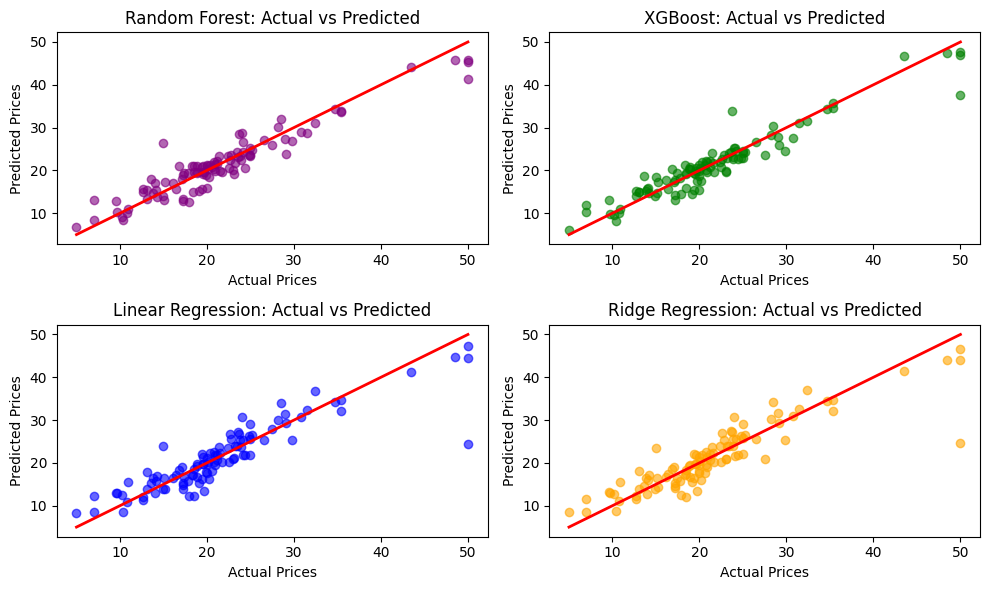

In [11]:
# Best Model - Let's assume Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

# Residual Plot
residuals = y_test - y_pred_rf
plt.scatter(y_pred_rf, residuals, alpha=0.6, color='blue')
plt.axhline(0, color='red', linewidth=2)
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residual Plot - Random Forest')
plt.show()

# Feature Importance
feature_importances = rf.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=features, palette='viridis')
plt.title('Feature Importance - Random Forest', fontsize=18)
plt.show()

# Polynomial Feature Interaction
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['lstat'], y=df['rm'], hue=df['lstat^2'] * df['rm'], palette='coolwarm')
plt.title('Interaction between LSTAT and RM', fontsize=18)
plt.xlabel('LSTAT')
plt.ylabel('RM')
plt.show()

# Create the new 'age_binned_New' column first
df['age_binned_New'] = pd.cut(df['age'], bins=[0, 35, 70, 100], labels=['New', 'Mid-aged', 'Old'])

# Now you can safely plot the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='age_binned_New', y='medv', data=df)
plt.title('Price Distribution by Age Category')
plt.xlabel('Age Category')
plt.ylabel('House Price')
plt.show()

# Visual comparison of predictions vs actual prices for all models
plt.figure(figsize=(10, 6))

# Actual vs Predicted for Random Forest
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Random Forest: Actual vs Predicted')

# Train XGBoost model
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)  # Make predictions with XGBoost

# Actual vs predicted prices for XGBoost
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred_xgb, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('XGBoost: Actual vs Predicted')

# Train Linear Regression model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)  # Make predictions with Linear Regression

# Actual vs predicted prices for Linear Regression
plt.subplot(2, 2, 3)
plt.scatter(y_test, y_pred_lr, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Linear Regression: Actual vs Predicted')

# Train Ridge Regression model
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)  # Make predictions with Ridge Regression

# Actual vs predicted prices for Ridge Regression
plt.subplot(2, 2, 4)
plt.scatter(y_test, y_pred_ridge, alpha=0.6, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Ridge Regression: Actual vs Predicted')

plt.tight_layout()
plt.show()
